In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d zalando-research/fashionmnist


 71% 49.0M/68.8M [00:01<00:00, 32.4MB/s]
100% 68.8M/68.8M [00:01<00:00, 54.7MB/s]


In [2]:
def extract_zip(source,dest):
  import zipfile
  data = zipfile.ZipFile(source,'r')
  data.extractall(dest)
  data.close()

extract_zip('/content/fashionmnist.zip','/content/')

In [1]:
import pandas as pd

df = pd.read_csv('/content/fashion-mnist_train.csv')

In [2]:
df.shape

(60000, 785)

In [3]:
df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,14.488767,32.830583,45.731017,52.064083,50.80245,50.459150,53.796217,51.396233,40.432733,26.083333,10.420583,4.079750,1.938183,1.177650,0.857983,0.461133,0.244300,0.092667,0.018333,0.006400,0.020617,0.098967,0.357200,0.767217,2.104583,7.331483,17.472317,32.009017,52.814583,79.349917,...,92.470233,90.523350,79.255767,62.576500,45.753283,43.970183,47.772400,38.841583,22.306933,9.280517,3.955417,0.631000,0.024633,0.218117,1.027250,4.352033,12.568183,20.847967,21.076467,17.152267,22.114933,30.559350,41.743617,51.506583,52.60855,46.479783,42.612733,45.309733,50.162100,46.438617,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,38.334549,57.633860,65.964300,68.603587,67.86885,67.370188,69.467796,67.912739,62.639596,51.818389,32.591095,20.118496,13.953210,10.718718,9.256114,6.768024,4.953103,2.850576,1.232175,0.548966,1.184869,2.912779,6.523878,9.702476,15.977721,30.056073,47.953585,65.625544,82.122567,95.340204,...,100.912013,99.731484,95.172029,88.844198,78.434831,76.970849,83.212136,74.477031,55.983447,37.937984,24.953295,8.146274,0.968474,4.444904,10.030021,20.912278,36.920905,48.909477,48.263137,42.173000,48.241135,54.902062,61.963606,68.331468,69.76041,67.476669,66.267004,66.737520,68.705817,65.944847,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2

In [4]:
arr = df.values
del df

In [26]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.layers import Input,Conv2D,Dense,Lambda,Flatten,Dropout,Add,Concatenate,MaxPooling2D,BatchNormalization,Activation,concatenate, AveragePooling2D,GlobalAveragePooling2D,ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt


In [6]:
arr.shape

(60000, 785)

In [7]:
def show(model,history,figsize):
  plt.figure(figsize=figsize)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.legend(loc = 'upper left')
  plt.show()
  plt.figure(figsize=figsize)
  plt.plot(history.history['accuracy'],label='accuracy')
  plt.plot(history.history['val_accuracy'],label='val_accuracy')
  plt.legend(loc = 'upper left')
  plt.show()
  return plot_model(model)


In [8]:
x_train = arr[:,1:] / 255
y_train = arr[:,0]
x_train.shape

(60000, 784)

In [9]:
y_train.shape

(60000,)

In [10]:
x_train = np.reshape(x_train,(x_train.shape[0],28,28,1))

In [11]:
x_train.shape

(60000, 28, 28, 1)

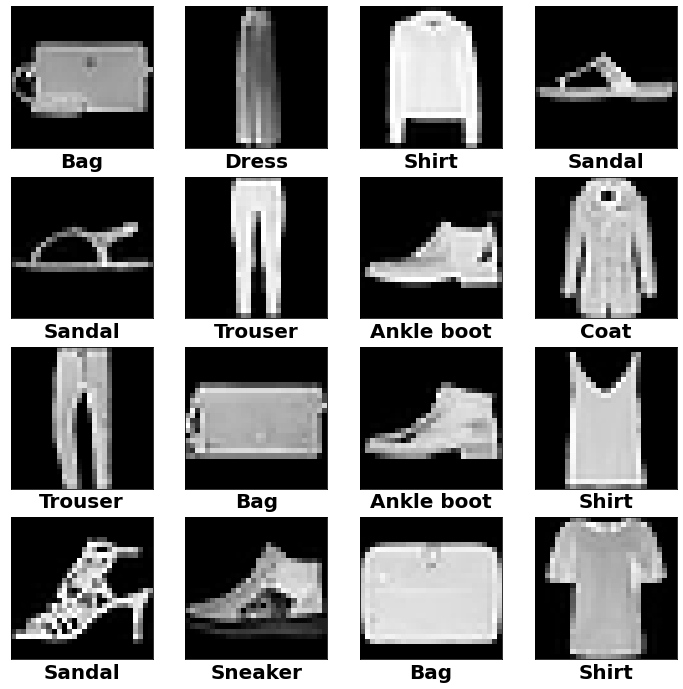

In [55]:
'''
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
'''
labels = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(12,12));
# print(axes)
for ax in axes:
  for col in ax:
    index = random.randint(1,x_train.shape[0])
    # pred = model.predict(np.expand_dims(test_x[index-1],0))
    # max = [np.amax(pred[0]),np.amax(pred[1]),np.amax(pred[2])]
    # maxi = np.argmax(max)
    # label = np.argmax(pred[maxi])
    col.set_xlabel(labels[y_train[index - 1]],fontdict={'size':20,"weight":'bold'})
    col.set_xticks([])
    col.set_yticks([])
    col.imshow(x_train[index-1].reshape(28,28),cmap='gray')
fig.savefig('sample_images.png')

In [12]:
df = pd.read_csv('/content/fashion-mnist_test.csv')

In [13]:
test_arr = df.values

In [14]:
df.shape

(10000, 785)

In [15]:
test_arr.shape

(10000, 785)

In [16]:
x_test = test_arr[:,1:] / 255
y_test = test_arr[:,0]
x_test = np.reshape(x_test,(x_test.shape[0],28,28,1))

In [17]:
x_test.shape

(10000, 28, 28, 1)

In [18]:
y_test.shape

(10000,)

In [19]:
drop_out_rate = .6
def IdentityBlock1(x,filters):
  br1 = Conv2D(filters,3,padding='same')(x)
  # br1 = BatchNormalization(3,momentum=.5)(br1)
  br1 = Activation('relu')(br1)
  br2 = Conv2D(filters,5,padding='same')(x)
  # br2 = BatchNormalization(3)(br2)
  br2 = Activation('relu')(br2)
  br3 = Conv2D(filters,7,padding='same')(x)
  # br3 = BatchNormalization(3,momentum=.5)(br3)
  br3 = Activation('relu')(br3)
  br4 = Conv2D(filters,1)(x)
  br4 = Activation('relu')(br4)
  br5 = MaxPooling2D((3,3),strides=(1,1),padding='same')(x)
  br6 = AveragePooling2D((3,3),strides=(1,1),padding='same')(x)
  x = Concatenate()([br1,br2,br3,br4,br5,br6])
  x = Conv2D(filters, (1,1), activation='relu')(x)
  return x

def residualBlock(x):
  br1 = Conv2D(x.shape[3],3,padding='same')(x)
  # br2 = BatchNormalization(3,momentum=.5)(br1)
  br1 = Activation('relu')(br1)
  br1 = Conv2D(x.shape[3],3,padding='same')(br1)
  # br2 = BatchNormalization(3,momentum=.5)(br1)
  br1 = Activation('relu')(br1)
  br1 = Conv2D(x.shape[3],3,padding='same')(br1)
  # br2 = BatchNormalization(3)(br1)
  br2 = Activation('relu')(br1)
  # br3 = Conv2D(x.shape[3],7,activation='relu',padding='same')(x)
  x = Add()([x,br1])
  x = Activation('relu')(x)
  return x

input = Input(shape=(28,28,1))
x = Conv2D(16,3)(input)
x = Activation('relu')(x)
x = IdentityBlock1(x,16)
x = Dropout(drop_out_rate)(x)
x = MaxPooling2D()(x)
x = IdentityBlock1(x,32)
x = Dropout(drop_out_rate)(x)
x = MaxPooling2D()(x)
x = IdentityBlock1(x,32)
x = Dropout(drop_out_rate)(x)
x = MaxPooling2D()(x)
x = Conv2D(64,3)(x)
x = Activation('relu')(x)
x = Dropout(drop_out_rate)(x)
x = Conv2D(10,1)(x)
x = Activation('softmax')(x)
x = Flatten()(x)
model = Model(inputs=input,outputs=x)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 26, 26, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 16)   2320        activation[0][0]                 
______________________________________________________________________________________________

In [22]:
model = tf.keras.models.load_model('model.h5')

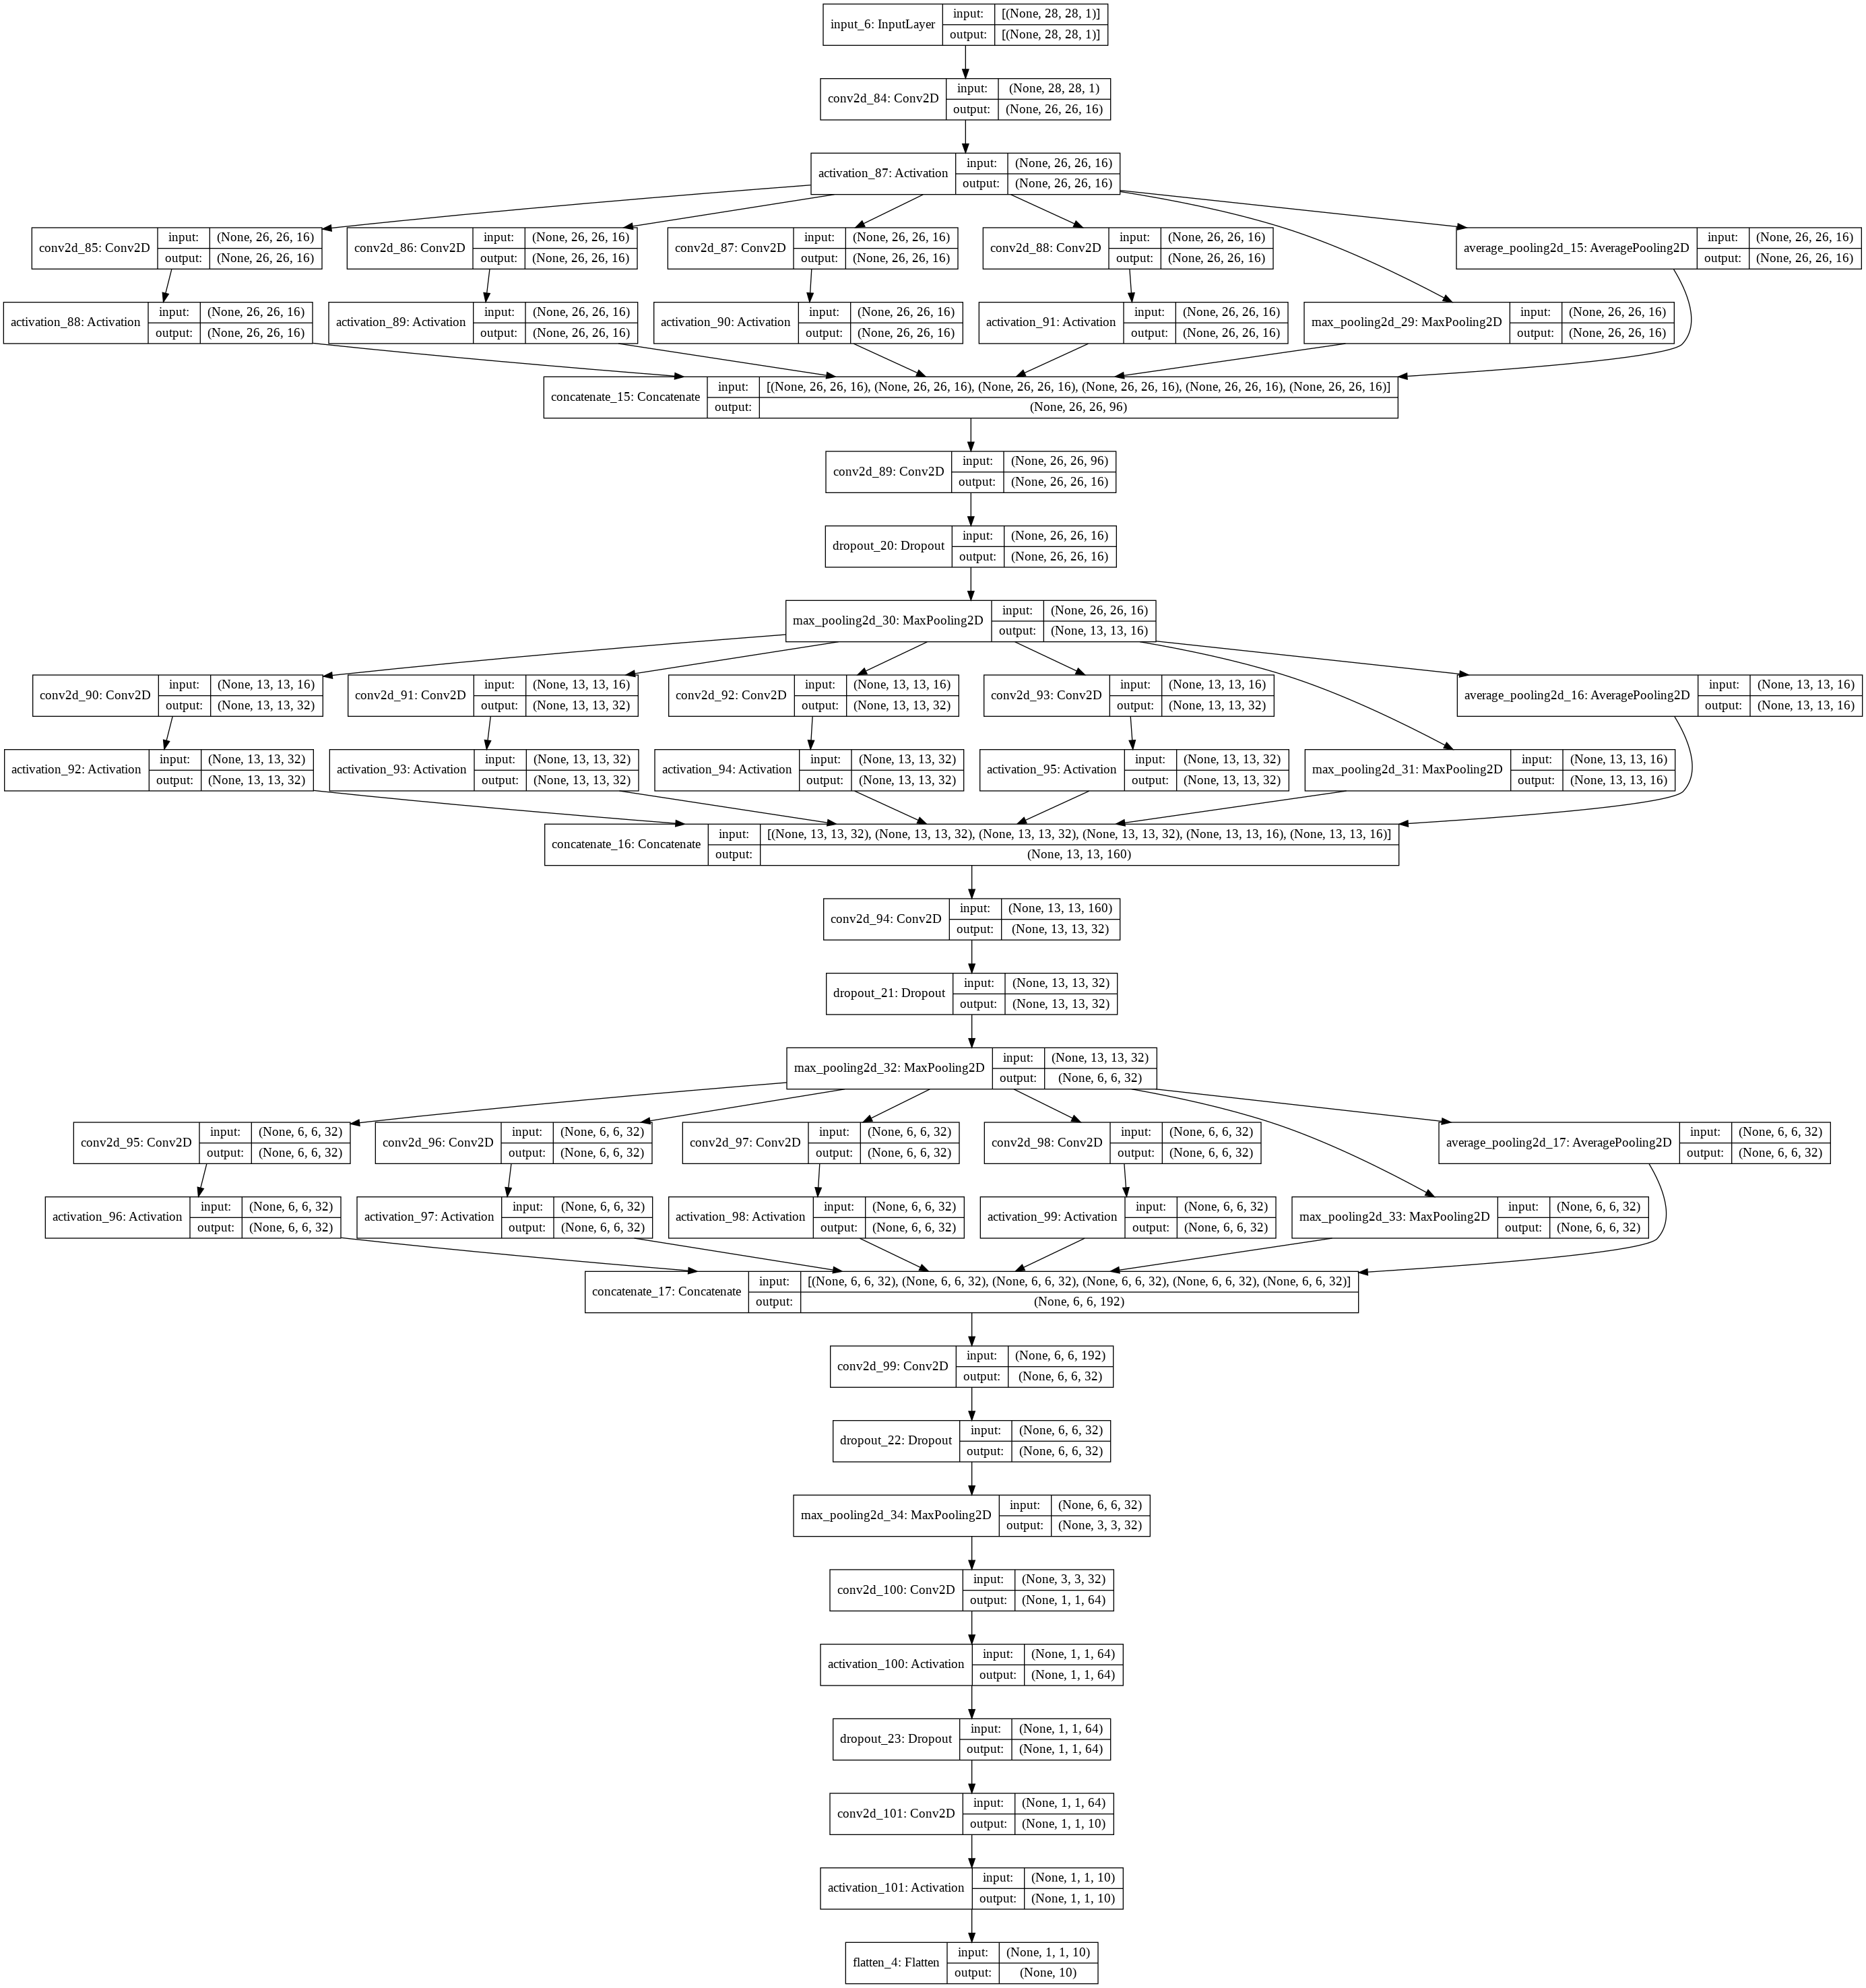

In [23]:
plot_model(model,show_shapes=True)

In [109]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=optimizer,loss = 'sparse_categorical_crossentropy',metrics='accuracy')

In [ ]:
def scheduler(epoch,lr):
  if (epoch <= 20):
    return .0001
  elif (epoch <= 40):
    return .0001
  return .00001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(x = x_train, y = y_train, epochs = 50, batch_size= 512 , validation_data=(x_test,y_test),verbose= 2 ,callbacks=[callback])


In [ ]:
  y = show(model,history,(10,6))

In [24]:
model.evaluate(x = x_test, y = y_test)

313/313 [==============================] - 9s 8ms/step - loss: 0.2271 - accuracy: 0.9806


[0.22707024216651917, 0.9805999994277954]

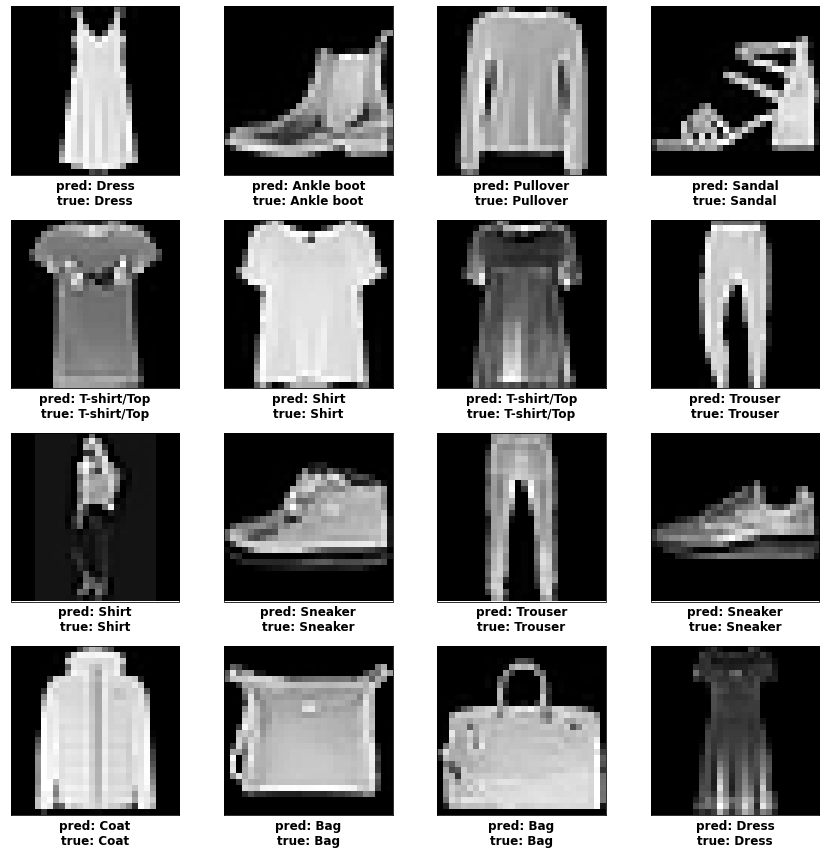

In [56]:
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(12,12))
fig.tight_layout()
# print(axes)
for ax in axes:
  for col in ax:
    index = random.randint(1,x_test.shape[0])
    pred = model.predict(np.expand_dims(x_test[index-1],0))
    pred = np.squeeze(pred)
    col.set_xlabel( "pred: " + labels[np.argmax(pred)] + "\ntrue: " + labels[y_test[index - 1]],fontdict={'size':12,"weight":'bold'})
    col.set_xticks([])
    col.set_yticks([])
    col.imshow(x_test[index-1].reshape(28,28),cmap='gray')
fig.savefig('prediction_result.png')